In [117]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [118]:
#img_num=1
img_num="frame0"

In [119]:
image_folder="../data/dt_segmentation_dataset/real/imgs/"
mask_folder="../data/dt_segmentation_dataset/real/labels/"

In [125]:
real=False 
if "real" in image_folder:
    real=True
real

True

In [126]:

#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#image

In [127]:
#ret,thresh = cv2.threshold(image,127,255,0)
#thresh

In [128]:
import random
r = lambda: random.randint(0,255)

def random_color():
    return (r(),r(),r())
#thresh

# Real
_background_
duckie
duckiebot
red_line
white_line
yellow_line

# Sim:
["background", "yellow_line","white_line","obstacles","duckiebot","red_line"]


In [131]:
real2sim = {0:0, 1:3, 2:4, 3:5, 4:2, 5:1}

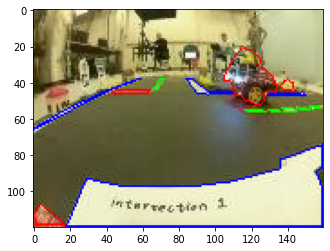

In [133]:
image = cv2.imread(f'{image_folder}/{img_num}.jpg')[:,:,::-1]
mask_flattened = np.load(f'{mask_folder}/{img_num}.npy')
h, w = 160, 120
mask_reshaped = mask_flattened.reshape(w,h)
image = cv2.imread(f'{image_folder}{img_num}.jpg')
from cv2_plt_imshow import cv2_plt_imshow as cv2_imshow
for i in range(1,6):
    thresh = (mask_reshaped==i).astype(np.uint8)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    #cnt = contours[1]
    if real:
        i = real2sim[i]
    if i==1:
        col=(0,255,0) #Yellow Line -> Green
    elif i==2:
        col=(255,0,0) #White Line -> Blue
    else:
        col=(0,0,255) #
    for cnt in contours:
        epsilon = 0.001*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        if len(approx>4) and area>1:
            #print(area/perimeter)
            if area/perimeter>0.1:
                pts = np.array(approx, np.int32)
                pts = pts.reshape((-1,1,2))
                image2 = cv2.polylines(image,[pts],True,col)
    cv2_imshow(image2)

In [134]:
category_names = ["background", "yellow_line","white_line","obstacles","duckiebot","red_line"]
categories = []
for i, name in enumerate(category_names):
    if i!=0:
        categories.append({"supercategory": name, "id":i, "name": name})

In [135]:
categories

[{'supercategory': 'yellow_line', 'id': 1, 'name': 'yellow_line'},
 {'supercategory': 'white_line', 'id': 2, 'name': 'white_line'},
 {'supercategory': 'obstacles', 'id': 3, 'name': 'obstacles'},
 {'supercategory': 'duckiebot', 'id': 4, 'name': 'duckiebot'},
 {'supercategory': 'red_line', 'id': 5, 'name': 'red_line'}]

In [136]:
import glob
orig_files = glob.glob(f"{image_folder}*.jpg")
import random
random.shuffle(orig_files)

In [137]:
files = orig_files[0:175]
import os
images = []
basename_to_id = {}
for i, file in enumerate(files):
    basename = os.path.basename(file)
    entry = {"file_name":basename, "height":120, "width":160, "id":i}
    basename_to_id[basename]=entry["id"]
    images.append(entry)
#images

In [138]:
#basename_to_id

In [139]:
#basename_to_id

In [140]:
ret,thresh = cv2.threshold(image,127,255,0)

In [141]:
thresh.shape

(120, 160, 3)

In [142]:
from cv2_plt_imshow import cv2_plt_imshow as cv2_imshow
annotation={}
def get_annotations(image_file_name, mask_file_name, annotation_id):
    global annotation, pts
    image_annotations=[]
    mask_flattened = np.load(mask_file_name)
    basename = os.path.basename(image_file_name)
    h, w = 160, 120
    mask_reshaped = mask_flattened.reshape(w,h)
    image = cv2.imread(image_file_name)
    for i in range(1,6):
        thresh = (mask_reshaped==i).astype(np.uint8)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        #cnt = contours[1]
        if real:
            i=real2sim[i]
        if i==1:
            col=(0,255,0)
        elif i==2:
            col=(255,0,0)
        else:
            col=(0,0,255)
        for cnt in contours:
            epsilon = 0.002*cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,epsilon,True)
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt,True)
            if len(approx>4) and area>1:
                #print(area/perimeter)
                if area/perimeter>0.1:
                    pts = np.array(approx, np.int32)
                    pts = pts.reshape((-1,1,2))
                    x, y = pts.reshape(-1,2)[:,0], pts.reshape(-1,2)[:,1]
                    bbox = [float(x.min()), float(y.min()), float(x.max()-x.min()),float(y.max()-y.min())]
                    annotation={"area":area,
                        "iscrowd":0,
                        "image_id": basename_to_id[basename],
                        "segmentation": [pts.flatten().tolist()],
                        "bbox": bbox,
                        "category_id": i,
                        "id":annotation_id
                       }
                    annotation_id+=1
                    image_annotations.append(annotation)
                    #print(annotation)
                    #image2 = cv2.polylines(image,[pts],True,col)
        #cv2_imshow(image2)
        
    #print(annotation_id)
    return image_annotations, annotation_id
#img_num=10205
img_num="frame25468"
mask_file_name = f'{mask_folder}{img_num}.npy'
image_file_name=  f'{image_folder}{img_num}.jpg'
annotation_id = 1
image_annotations=get_annotations(image_file_name, mask_file_name, annotation_id)
#image_annotations

In [143]:
annotations=[]
from tqdm import tqdm
annotation_id = 1
for file in tqdm(files):
    basename = os.path.basename(file)
    mask_file_name = f'{mask_folder}{basename.replace(".jpg",".npy")}'
    image_file_name=  f'{image_folder}{basename}'
    image_annotations, annotation_id =get_annotations(image_file_name, mask_file_name, annotation_id)
    annotations+=image_annotations

100%|██████████| 175/175 [00:00<00:00, 1049.00it/s]


In [148]:
len(annotations)

1222

In [149]:
data={"categories":categories, "images":images,"annotations":annotations}

In [150]:
#data["images"]

In [151]:
import json

In [152]:
#data["annotations"]

In [153]:
with open("../data/duckie_real_train.json","w") as f:
    json.dump(data,f)

In [539]:
#data